In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dython import nominal, data_utils
from scipy.stats import norm, skew

warnings.filterwarnings('ignore')

In [2]:
raw = pd.read_csv('./data/autos.csv', encoding='ISO-8859-1')
raw.sample(n=5)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
349915,2016-04-03 17:25:22,Mitsubishi_Space_Star_GDI_1800_GLX,privat,Angebot,1570,test,bus,1999,manuell,122,andere,125000,7,benzin,mitsubishi,nein,2016-04-03 00:00:00,0,55425,2016-04-07 01:16:19
94709,2016-03-17 11:36:36,Ford_Focus_C_MAX_2.0_TDCi_DPF_Ghia,privat,Angebot,2299,control,bus,2004,manuell,136,focus,150000,9,diesel,ford,ja,2016-03-17 00:00:00,0,38723,2016-03-31 20:17:01
260093,2016-03-08 20:25:43,Mercedes_Benz_CLS_350_CDI_7G_TRONIC_Scheckheft...,privat,Angebot,19950,test,coupe,2010,automatik,224,andere,150000,5,diesel,mercedes_benz,nein,2016-03-08 00:00:00,0,60486,2016-04-05 13:18:53
51063,2016-03-25 00:56:18,Renault_Laguna_Limousine_1.8_16V_Top_Zustand,privat,Angebot,950,control,limousine,1999,manuell,120,laguna,150000,5,benzin,renault,nein,2016-03-25 00:00:00,0,86720,2016-04-06 04:46:16
30614,2016-03-30 22:38:18,Golf_2_1.8_kr,privat,Angebot,625,control,limousine,1986,manuell,90,golf,150000,8,benzin,volkswagen,NaN,2016-03-30 00:00:00,0,23972,2016-03-30 22:38:18


In [3]:
raw.describe(include='all')

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
count,371528,371528,371528,371528,3.715280e+05,371528,333659,371528.000000,351319,371528.000000,351044,371528.000000,371528.000000,338142,371528,299468,371528,371528.0,371528.00000,371528
unique,280500,233531,2,2,NaN,2,8,NaN,2,NaN,251,NaN,NaN,7,40,2,114,NaN,NaN,182806
top,2016-03-24 14:49:47,Ford_Fiesta,privat,Angebot,NaN,test,limousine,NaN,manuell,NaN,golf,NaN,NaN,benzin,volkswagen,nein,2016-04-03 00:00:00,NaN,NaN,2016-04-07 06:45:59
freq,7,657,371525,371516,NaN,192585,95894,NaN,274214,NaN,30070,NaN,NaN,223857,79640,263182,14450,NaN,NaN,17
mean,NaN,NaN,NaN,NaN,1.729514e+04,NaN,NaN,2004.577997,NaN,115.549477,NaN,125618.688228,5.734445,NaN,NaN,NaN,NaN,0.0,50820.66764,NaN
std,NaN,NaN,NaN,NaN,3.587954e+06,NaN,NaN,92.866598,NaN,192.139578,NaN,40112.337051,3.712412,NaN,NaN,NaN,NaN,0.0,25799.08247,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.00000,NaN
25%,NaN,NaN,NaN,NaN,1.150000e+03,NaN,NaN,1999.000000,NaN,70.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30459.00000,NaN
50%,NaN,NaN,NaN,NaN,2.950000e+03,NaN,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49610.00000,NaN
75%,NaN,NaN,NaN,NaN,7.200000e+03,NaN,NaN,2008.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71546.00000,NaN


In [5]:
raw['vehicleType'].unique()

array([nan, 'coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus',
       'kombi', 'andere'], dtype=object)

In [4]:
raw['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'porsche', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'land_rover', 'lada'], dtype=object)

In [5]:
raw['fuelType'].unique()

array(['benzin', 'diesel', nan, 'lpg', 'andere', 'hybrid', 'cng',
       'elektro'], dtype=object)

## Handling missing values

In [3]:
raw.isna().sum()

dateCrawled                0
name                       0
seller                     0
offerType                  0
price                      0
abtest                     0
vehicleType            37869
yearOfRegistration         0
gearbox                20209
powerPS                    0
model                  20484
kilometer                  0
monthOfRegistration        0
fuelType               33386
brand                      0
notRepairedDamage      72060
dateCreated                0
nrOfPictures               0
postalCode                 0
lastSeen                   0
dtype: int64

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [5]:
raw = raw.astype({
    'yearOfRegistration': object,
    'powerPS': object,
    'monthOfRegistration': object,
    'nrOfPictures': object,
    'postalCode': object
})

In [6]:
raw.loc[:, 'vehicleType'] = raw.loc[:, 'vehicleType'].fillna('any')
raw.loc[:, 'gearbox'] = raw.loc[:, 'gearbox'].fillna('any')
raw.loc[:, 'model'] = raw.loc[:, 'model'].fillna('any')
raw.loc[:, 'fuelType'] = raw.loc[:, 'fuelType'].fillna('any')
raw.loc[:, 'notRepairedDamage'] = raw.loc[:, 'notRepairedDamage'].fillna('not specified')

raw.isna().sum()

dateCrawled            0
name                   0
seller                 0
offerType              0
price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
nrOfPictures           0
postalCode             0
lastSeen               0
dtype: int64

## Feature engineering

In [7]:
filtered_raw = raw.drop(['dateCrawled', 'lastSeen', 'name'], axis=1)
filtered_raw['monthCreated'] = pd.DatetimeIndex(filtered_raw['dateCreated']).month
filtered_raw.drop(['dateCreated'], axis=1, inplace=True)

filtered_raw.sample(n=5)

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,nrOfPictures,postalCode,monthCreated
359778,privat,Angebot,3000,control,limousine,2008,manuell,125,megane,125000,7,diesel,renault,ja,0,7318,3
59857,privat,Angebot,12500,control,suv,1975,manuell,69,andere,70000,12,benzin,land_rover,nein,0,24960,3
45925,privat,Angebot,600,test,andere,1984,manuell,55,caddy,5000,1,diesel,volkswagen,nein,0,59348,3
362081,privat,Angebot,2600,control,limousine,1988,automatik,147,andere,150000,5,diesel,mercedes_benz,nein,0,72661,3
185714,privat,Angebot,2990,control,kombi,2002,automatik,143,c_klasse,150000,7,diesel,mercedes_benz,nein,0,33100,3


In [8]:
filtered_raw.duplicated().sum()

12907

In [9]:
filtered_raw.drop_duplicates(inplace=True)
print(len(filtered_raw))
filtered_raw.nunique()

358621


seller                    2
offerType                 2
price                  5597
abtest                    2
vehicleType               9
yearOfRegistration      155
gearbox                   3
powerPS                 794
model                   252
kilometer                13
monthOfRegistration      13
fuelType                  8
brand                    40
notRepairedDamage         3
nrOfPictures              1
postalCode             8150
monthCreated             10
dtype: int64

In [10]:
filtered_raw.drop(['nrOfPictures'], axis=1, inplace=True)

In [11]:
filtered_raw.drop(filtered_raw[filtered_raw['powerPS'] == 0].index, inplace=True)

## Data Exploration

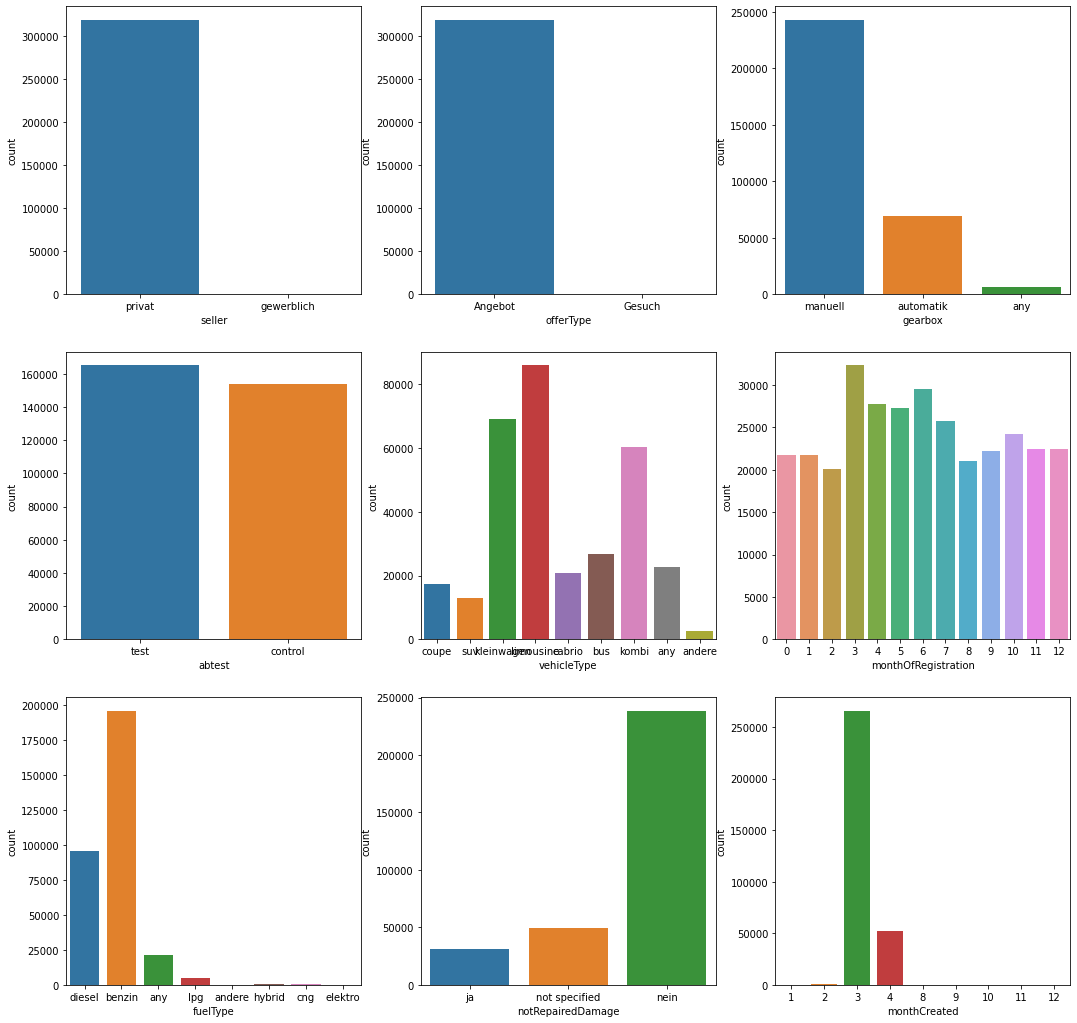

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
sns.countplot(x='seller', data=filtered_raw, ax= axes[0,0])
sns.countplot(x='offerType', data=filtered_raw, ax= axes[0,1])
sns.countplot(x='gearbox', data=filtered_raw, ax= axes[0,2])
sns.countplot(x='abtest', data=filtered_raw, ax= axes[1,0])
sns.countplot(x='vehicleType', data=filtered_raw, ax= axes[1,1])
sns.countplot(x='monthOfRegistration', data=filtered_raw, ax= axes[1,2])
sns.countplot(x='fuelType', data=filtered_raw, ax= axes[2,0])
sns.countplot(x='notRepairedDamage', data=filtered_raw, ax= axes[2,1])
sns.countplot(x='monthCreated', data=filtered_raw, ax= axes[2,2])
plt.show()

In [13]:
updated_raw = filtered_raw.drop(['seller', 'offerType', 'monthCreated'], axis= 1)
updated_raw.head(5)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode
1,18300,test,coupe,2011,manuell,190,any,125000,5,diesel,audi,ja,66954
2,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,not specified,90480
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,91074
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,60437
5,650,test,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja,33775


## Correlations

In [14]:
data_corr_result = nominal.associations(updated_raw, mark_columns=True, compute_only=True)
data_corr = pd.DataFrame(data_corr_result['corr'])

data_corr.sort_values(["price (con)"], ascending = False, inplace = True)
data_corr["price (con)"]

price (con)                  1.000000
fuelType (nom)               0.096930
brand (nom)                  0.021318
vehicleType (nom)            0.019141
model (nom)                  0.009142
powerPS (con)                0.007164
notRepairedDamage (nom)      0.005146
abtest (nom)                 0.001649
gearbox (nom)                0.000387
kilometer (con)              0.000114
yearOfRegistration (con)    -0.000434
monthOfRegistration (con)   -0.002550
postalCode (con)            -0.002985
Name: price (con), dtype: float64

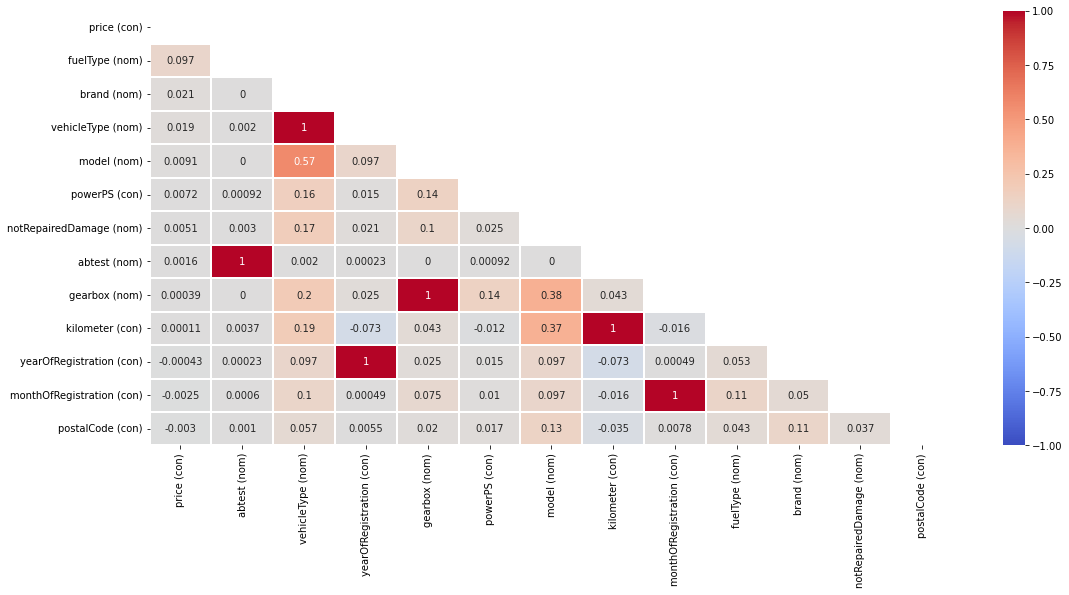

In [15]:
plt.figure(figsize=(18, 8))
mask = np.zeros_like(data_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_corr, vmin=-1, vmax=1, cmap='coolwarm', mask = mask,annot=True, linewidths=0.1)
plt.show()

## Baseline

In [16]:
from sklearn.model_selection import train_test_split

continuous_features = ['powerPS', 'kilometer', 'price']
continuous_predictors = ['powerPS', 'kilometer']
categorical_features = ['vehicleType', 'brand', 'fuelType']

data = updated_raw[['powerPS', 'vehicleType', 'brand', 'fuelType', 'kilometer', 'price']]

In [17]:
skewness = data[continuous_features].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
data[skewed_features] = np.log1p(data[skewed_features].astype(float))

skewed_features

Index(['powerPS', 'kilometer', 'price'], dtype='object')

In [18]:
skewed_predictors = ['powerPS', 'kilometer']

In [19]:
X = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

In [20]:
X_train.sample(n=5)

,powerPS,vehicleType,brand,fuelType,kilometer
279429,4.948760,bus,volkswagen,benzin,11.289794
70762,4.025352,kleinwagen,opel,benzin,11.918397
59260,4.110874,kombi,seat,benzin,10.596660
99512,4.812184,kombi,volkswagen,benzin,10.308986
349697,4.595120,cabrio,audi,benzin,8.517393


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, continuous_predictors),
    ]
)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor())
])

In [22]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
mean_absolute_error(y_val, y_pred)

0.648658180137547

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__n_estimators": [20, 40],
    "classifier__max_depth": [5, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=3)
search.fit(X_train, y_train)
print("Best parameter (score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (score=0.373):
{'classifier__max_depth': 8, 'classifier__n_estimators': 40}


In [23]:
pipe_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(n_estimators=50, max_depth=10, max_features="sqrt"))
])
pipe_2.fit(X_train, y_train)
y_pred_2 = pipe_2.predict(X_val)
mean_absolute_error(y_val, y_pred_2)

0.7680978639677053

In [25]:
pipe_3 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(n_estimators=40, max_depth=8, max_features="sqrt"))
])
pipe_3.fit(X_train, y_train)
y_pred_3 = pipe_3.predict(X_val)
mean_absolute_error(y_val, y_pred_3)

0.8051895753785769